In [1]:
import networkx as nx
import numpy as np
import random
random.seed;
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg
import time
import math
from scipy import stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle

import sys
sys.path += ['/Package']  ### Specify the directory where the Package is
from clustering_with_best import *


import warnings
warnings.filterwarnings("ignore")

In [4]:
n = 5000 #  number of nodes
n_average = 10 # number of average
fraction = int(n/2) # number of nodes in the first family
number_sim = 15 # number of points where to do the simulation

classes = np.zeros(n)
classes[:fraction] = 1

overlap = np.zeros((number_sim,n_average)) # our proposed algorithm
overlap_A = np.zeros((number_sim,n_average)) # clustering using the adjacency matrix
overlap_D_1_A = np.zeros((number_sim,n_average)) # clustering using the random walk laplacian
overlap_L_best = np.zeros((number_sim,n_average)) # clustering using the "best" eigenvector of the random walk laplacian
overlap_saa = np.zeros((number_sim,n_average))  # originally proposed bethe-hessian

##### create the c_in and c_out vectors ########

c_out = 1
c_in = 2
c_in_v = np.zeros(number_sim)
c_out_v = np.zeros(number_sim)
for i in range(number_sim):
    c_in_v[i] = c_in + i
    c_out_v[i] = c_out
    
    
################################################
    
    
### These are the various distributions of theta used
    

'''In the following three cases we create two ordered vectors of size n/2 that are equally placed in the two classes.
By decommenting the command random.shuffle(theta) this can be used to see the action of the degree on the variance'''


theta = np.random.uniform(3,10,size = n)**4
# theta = np.ones(n)
theta = theta/np.mean(theta)
assortativity = 1
n_eigs = 20 # number of eigenvalues among which look for the "best" eigenvector of the random walk laplacian

## Simulation

In [6]:
t0 = time.time()

for i in range(number_sim):
    for k in range(n_average):
        
        c_in = c_in_v[i]

        A = adj(c_in,c_out,theta,fraction) # create the adjacency matrix
        d = np.sum(A.astype(float),axis = 0) # degree vector
        phi = np.mean(theta**2) # second moment of the theta vector 
        r = (c_in + c_out)/(c_in - c_out) # our choice of r
        c = (c_in + c_out)/2 # average degree

        predict, eigenvalues, X, ov = BH(A, classes,r,assortativity) # our proposed method D - zetaA
        predict, eigenvalues, X, ov_l = lap(A,classes,assortativity,2) # D^{-1}A
        predict, eigenvalues, X, ov_l_best = lap(A,classes,assortativity,n_eigs) # D^{-1}A using the best eigenvector
        predict, eigenvalues, X, ov_adj = adj_cluster(A,classes,assortativity,2) # A  
        predict, eigenvalues, X, ov_saa = BH(A, classes,np.sqrt(c*phi),assortativity) # D - sqrt{rho(B)}A   
         
        # storing the overlaps
            
        overlap[i][k] += ov
        overlap_A[i][k] += ov_adj
        overlap_D_1_A[i][k] += ov_l
        overlap_L_best[i][k] = ov_l_best
        overlap_saa[i][k] += ov_saa
        
        OUT = 'Completion : i = ' + str(i+1) + '/'+str(number_sim) + ', j = ' + str(k+1) + ' Time : ' + str(time.time()-t0)
        sys.stdout.write('\r%s' % OUT)
        sys.stdout.flush()

        
ov_vector = np.sum(overlap, axis = 1)/n_average
var_vector = (np.sum(overlap**2, axis = 1)/n_average - (np.sum(overlap, axis = 1)/n_average)**2)

ov_vector_A = np.sum(overlap_A, axis = 1)/n_average
var_vector_A = (np.sum(overlap_A**2, axis = 1)/n_average - (np.sum(overlap_A, axis = 1)/n_average)**2)

ov_vector_D_1_A = np.sum(overlap_D_1_A, axis = 1)/n_average
var_vector_D_1_A = (np.sum(overlap_D_1_A**2, axis = 1)/n_average - (np.sum(overlap_D_1_A, axis = 1)/n_average)**2)

ov_vector_L_best = np.sum(overlap_L_best, axis = 1)/n_average
var_vector_L_best = (np.sum(overlap_L_best**2, axis = 1)/n_average - (np.sum(overlap_L_best, axis = 1)/n_average)**2)

ov_vector_saa = np.sum(overlap_saa, axis = 1)/n_average
var_vector_saa = (np.sum(overlap_saa**2, axis = 1)/n_average - (np.sum(overlap_saa, axis = 1)/n_average)**2)

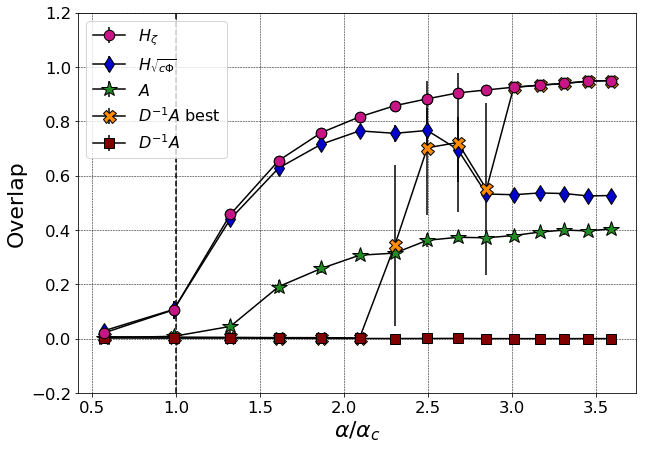

In [5]:
plt.figure(figsize = (10,7))
alpha = (c_in_v - c_out)/(np.sqrt(0.5*(c_in_v+c_out)))
lw = 1.5
phi = np.mean(theta**2)
alpha_c = 2/np.sqrt(phi)

plt.errorbar(alpha/alpha_c,ov_vector,yerr=np.sqrt(var_vector/2),fmt = '.',color = 'k', markerfacecolor = 'mediumvioletred',markersize = 21,label = r'$H_\zeta$', ls = '-', linewidth = lw)
plt.errorbar(alpha/alpha_c,ov_vector_saa,yerr=np.sqrt(var_vector_saa/2),fmt = 'd',color = 'k', markerfacecolor = 'mediumblue',markersize = 12,label = r'$H_{\sqrt{c\Phi}}$', ls = '-', linewidth = lw)
plt.errorbar(alpha/alpha_c,ov_vector_A,yerr=np.sqrt(var_vector_A/2),fmt = '*',color = 'k', markerfacecolor = 'forestgreen',markersize = 16,label = r'$A$', ls = '-', linewidth = lw)
plt.errorbar(alpha/alpha_c,ov_vector_L_best,yerr=np.sqrt(var_vector_L_best/2),fmt = 'X',color = 'k', markerfacecolor = 'darkorange',markersize = 13,label = r'$D^{-1}A$ best', ls = '-', linewidth = lw)
plt.errorbar(alpha/alpha_c,ov_vector_D_1_A,yerr=np.sqrt(var_vector_D_1_A/2),fmt = 's',color = 'k', markerfacecolor = 'maroon',markersize = 10,label = R'$D^{-1}A$',ls = '-', linewidth = lw)
plt.errorbar(alpha/alpha_c,ov_vector,yerr=np.sqrt(var_vector/2),fmt = '.',color = 'k', markerfacecolor = 'mediumvioletred',markersize = 21)
plt.axvline(1,linestyle = '--', color = 'k');
plt.legend(loc = 2,fontsize = 16)
plt.ylim(-0.2,1.2)
plt.xlabel(r'$\alpha/\alpha_c$',fontsize = 22)
plt.grid(linestyle = '--', color = 'k', linewidth = 0.5)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16.5)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16.5)
plt.ylabel('Overlap',fontsize = 22);

plt.show()